# Embedding sparse vectors into high-but-lower-dimensional dense space

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/mnist/notebooks/catvar-embeddings-homebrew.ipynb)

One-hot vectors are simple but the vocabulary size can make word vectors extremely long; high dimensionality. And they are very sparse, mostly zeros.

Word embeddings, on the other hand, embed that massive dimensional space into a smaller, dense space. For example, [GloVE](https://nlp.stanford.edu/projects/glove/) has pre-trained word embeddings of various sizes such as 50 and 300 dimensions. Unlike word vectors, we need to do some training to compute embeddings. I've used pre-trained word-to-embedding dictionaries to good effect, but we can also train and embedding specific to our task as part of our model, using an embedding layer.

In this notebook, I'm going to explore creating dense vectors, first by playing around with random dense vectors for words and then move on to trying to create dense vectors for categorical variables.

## Getting random but dense not sparse vectors

In [word-vectors](word-vectors.ipynb), we created sparse vectors representing words. When added together, these create bag of words (BOW) representations of documents. We can just turn on the particular position of a word in the vector if that word is present in the document. 

If we are passing words individually to a recurrent neural network (RNN), then these sparse vectors can get pretty big. If there are 20,000 words in the dictionary, we might have vectors of size 20,000. What we need is a dense representation that still gives us unique representations of each word.  (We also used to the hash trick also to try to shrink the size of the sparse vectors, but they are still sparse.)

In [2]:
import numpy as np
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [3]:
# sample tweets from my twitter inbox with added text for experimentation
samples = [
    """Tesla Motors has nothing to do with this tweet.
    On those rare occasions when I really, really need to reduce the
    size of a file I use "xz -9". Today I found out about the "extreme" setting
    and "xz -e9" squeezed files down another 15% or so. It is not exactly quick,
    but that doesn't really matter in such cases!""",
    
    """Securities and exchange commission has nothing to do with this tweet.
    Do grad students get paid a lot? No. But do we at least have solid
    job security? Also, no. But are we at least ensured a stress-free work
    environment with a healthy work-life balance? Still, also no.""",

    """A design process hyperfocused on A/B testing can result in dark patterns even
    if that’s not the intent. That’s because most A/B tests are based on metrics
    that are relevant to the company’s bottom line, even if they result in harm to users."""
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(samples)
words = tokenizer.word_index.keys() # get tokenized words

If we are not using a hash function but instead dense factors, we need a dictionary to keep track of the word to vector mapping. But, we can create vectors of any length and get very little chance of collision. For example, even with a single floating-point number between 0 and 1, with our 96 words in the vocabulary, there's almost no chance of collision

In [4]:
def hashwords(words, dimensionality = 4):
    return {w:np.random.random(size=dimensionality) for w in words}

In [5]:
index = hashwords(words, dimensionality=4)
list(index.items())[:10]

[('a', array([0.26118067, 0.13403861, 0.61027729, 0.11396323])),
 ('to', array([0.32063386, 0.1671196 , 0.51435688, 0.0872403 ])),
 ('do', array([0.55765043, 0.03150559, 0.67089196, 0.74617893])),
 ('the', array([0.68176234, 0.91857488, 0.64404817, 0.71503278])),
 ('with', array([0.06174732, 0.39597205, 0.37767156, 0.69615172])),
 ('on', array([0.81636026, 0.46140716, 0.36661449, 0.44821374])),
 ('i', array([0.01798426, 0.91843474, 0.45449603, 0.57520315])),
 ('really', array([0.32699358, 0.76191127, 0.33386607, 0.90638247])),
 ('but', array([0.54423901, 0.38834331, 0.62148659, 0.39675912])),
 ('in', array([0.46300173, 0.80064166, 0.65154614, 0.24719102]))]

In [6]:
ncollisions = len(index) - len(set([tuple(a) for a in index.values()]))
print(f"There were {ncollisions} collisions between dense word vectors")

There were 0 collisions between dense word vectors


Note that if we only use dimensionality=1, then we are right back to label encoding, just with a floating-point number instead of an integer. We need at least a dimensionality of two.

What happens if we need to send an entire document not just a single word into a model? We need a continuous bag of words (CBOW), which is easy for one hot encoding.  We just turn on all relevant word-columns. For dense vectors, we either need to concatenate them together or sum or average them into a single vector. If documents are different length, then concatenating them doesn't work because models typically require fixed length input.

Those vectors are dense but there is literally no meaning to the values in the vector positions. Two similar words are in no way similar in some kind of semantic space. We are not helping the model very much. 

In [7]:
import pandas as pd
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    return df_ratings

df_ratings = load(n=10_000)
df_ratings.head(5)

,userId,movieId,rating
0,239,50,4.5
1,265,1214,2.0
2,275,541,5.0
3,428,5064,3.0
4,229,150,5.0


In [8]:
df_ratings['movieId'].head(5).values

array([  50, 1214,  541, 5064,  150])

### Compressing arbitrarily large IDs to 1..n indexes

Rather than deal with arbitrarily large integers representing the various IDs, let's compress that down to unique but adjacent integers. This is also how I would handle string to integer encoding.

In [9]:
catencoders = {} # convert real movie, user ID to compressed index value
index_to_id = {} 
def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    catencoders[colname] = df[colname].cat.categories
    index_to_id[colname] = df[colname].cat.categories.values
    df[colname] = df[colname].cat.codes + 1 # encode 1..n

That function compresses one column at a time and modifies the data frame in place. Compare the movie IDs with the values above. We have converted `[3696,  281,  592, 1293, 4446]` to `[4, 1, 2, 3, 5]`:

In [10]:
df_tiny = df_ratings.head(5).copy()
compress_cats(df_tiny, "movieId")
df_tiny

,userId,movieId,rating
0,239,1,4.5
1,265,4,2.0
2,275,3,5.0
3,428,5,3.0
4,229,2,5.0


We have also gotten a mapping from ID to the tiny index that we can use later:

In [11]:
catencoders['movieId']

Int64Index([50, 150, 541, 1214, 5064], dtype='int64')

Later when we want to convert movie IDs to indexes, we can reuse the catencoders, but remember that pandas will display the values using the category "ID names" not the code unless we convert it to the "code":

In [12]:
df_tiny = df_ratings.head(5).copy()
df_tiny['movieId'] = pd.Categorical(df_tiny['movieId'], categories=catencoders['movieId'], ordered=True)
df_tiny['movieId'] = df_tiny['movieId'].cat.codes+1
df_tiny

,userId,movieId,rating
0,239,1,4.5
1,265,4,2.0
2,275,3,5.0
3,428,5,3.0
4,229,2,5.0


### Map movie to user

Let's try mapping users to movies with a neural network. Presumably people self filter the movies they watch and so there could be information that will tell us about users and/or movies.

In [13]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras.datasets import mnist
from tensorflow.keras import models, layers, callbacks, optimizers
import tqdm
from tqdm.keras import TqdmCallback
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

In [14]:
compress_cats(df_ratings, "userId")
compress_cats(df_ratings, "movieId")
nusers = len(df_ratings.groupby('userId').count())
nmovies = len(df_ratings.groupby('movieId').count())
n = len(df_ratings)
n, nusers, nmovies

(10000, 596, 3595)

The input to the neural network will be one hot encoded movie identifiers. The output will also be one hot encoded user IDs, but keras will handle that part for us.

In [15]:
X = pd.get_dummies(df_ratings['movieId'])
y = df_ratings['userId'] #pd.get_dummies(df_ratings['userId'])
X.shape, y.shape

((10000, 3595), (10000,))

In [16]:
X.head(3)

,1,2,3,4,5,6,7,8,9,10,...,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
y.head(3)

0    236
1    261
2    270
Name: userId, dtype: int16

In [18]:
layer1 = 20
layer2 = 200
batch_size = 50
model = models.Sequential()
model.add(layers.Dense(layer1, name='embedding', input_dim=nmovies, activation='relu')) # input_shape=(n,nmovies)
model.add(layers.Dense(layer2, activation='relu'))
model.add(layers.Dense(nusers+1, activation='softmax'))

opt = optimizers.RMSprop()

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
#model.summary()

In [19]:
history = model.fit(X, y,
                    shuffle=True,
                    epochs=50,
                    validation_split=0.10,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

y_pred = model.predict(X.values.reshape(-1,nmovies))
y_pred = np.argmax(y_pred, axis=1)
val_accur = accuracy_score(y, y_pred)
print("Keras validation accuracy", val_accur)

import matplotlib.pyplot as plt

plt.ylabel("Accuracy")
plt.xlabel("Epochs")

accur = history.history['accuracy']
plt.plot(accur, label='train_accuracy')
val_accur = history.history['val_accuracy']
plt.plot(val_accur, label='valid_accuracy')
# plt.xlim(0, 200)
# plt.ylim(0.5, 1.02)
plt.legend(loc='lower right')
plt.show()


Keras validation accuracy 0.3035


<Figure size 640x480 with 1 Axes>

Validation error is terrible, but [Oliver](http://www.zeigermann.eu/) says we care about training error for getting embeddings since we won't be using the predictions.  In his example, he only has about 10% accuracy so I'm going to consider roughly 30% quite good. :)

[Here](https://djcordhose.github.io/ml-workshop/2019-embeddings.html#/17), Oliver explains how to get the embeddings out. These are the outputs from the first constrained layer.

In [20]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
w.shape
w

array([[ 0.03, -0.07, -0.05, ..., -0.14, -0.1 , -0.09],
       [ 0.05,  0.07, -0.08, ...,  0.13,  0.08,  0.01],
       [-0.05,  0.01, -0.09, ...,  0.04,  0.  , -0.07],
       ...,
       [-0.01, -0.01, -0.03, ...,  0.03, -0.  , -0.05],
       [-0.04,  0.03, -0.04, ...,  0.01,  0.01,  0.01],
       [-0.11,  0.05, -0.06, ..., -0.01, -0.1 ,  0.15]], dtype=float32)

In [21]:
uniq_movieIds = np.unique(df_ratings['movieId'])
uniq_movieIds_onehot = pd.get_dummies(uniq_movieIds)
uniq_movieIds_onehot.head(2)

,1,2,3,4,5,6,7,8,9,10,...,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
uniq_movieIds_onehot.shape, w.shape, b.shape

((3595, 3595), (3595, 20), (20,))

The shape of the weight matrix is the transpose of what I would expect. For example, I like the convention of a row being the weights of a single neuron. Since I have 20 neurons, I would expect 20 rows, but still we can just reverse the operators of the dot product. The following should give us the output of the embedding layer:  take the dot product of every input movie one-hot and multiply times the weight vector then add the bias. Note: The dot product is really just selecting the ith row of w for one-hot turned on at position i.  A row in w is the set of weights across neurons for a particular feature, a word in our case. That gives us a vector in 20-space where each dimension is some semantic meaning we got from a neuron.

In [23]:
movie_embeddings = np.dot(uniq_movieIds_onehot, w) + b
print(movie_embeddings.shape)
movie_embeddings

(3595, 20)


array([[ 0.14,  0.  ,  0.04, ..., -0.01, -0.  , -0.  ],
       [ 0.16,  0.15,  0.  , ...,  0.26,  0.18,  0.1 ],
       [ 0.06,  0.08, -0.  , ...,  0.17,  0.1 ,  0.02],
       ...,
       [ 0.09,  0.06,  0.05, ...,  0.16,  0.1 ,  0.04],
       [ 0.07,  0.1 ,  0.05, ...,  0.14,  0.1 ,  0.1 ],
       [-0.  ,  0.12,  0.03, ...,  0.13,  0.  ,  0.24]], dtype=float32)

In [24]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [25]:
df_movies['movieId'] = pd.Categorical(df_movies['movieId'], categories=catencoders['movieId'], ordered=True)
df_movies['movieId'] = df_movies['movieId'].cat.codes+1
df_movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [26]:
df_ratings.merge(df_movies, on='movieId')

,userId,movieId,rating,title,genres
0,236,39,4.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1,273,39,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
2,130,39,4.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
3,18,39,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
4,208,39,4.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
9995,50,1771,3.5,Diary of a Chambermaid (Journal d'une femme de...,Comedy|Drama
9996,36,1720,2.0,"Longest Yard, The (1974)",Comedy
9997,585,419,1.5,Bulletproof (1996),Action|Comedy|Crime
9998,464,1775,3.5,All That Heaven Allows (1955),Drama|Romance


### Movie+user -> rating

Ok, Let's try to map both the movie and the user to a rating.

In [27]:
df_ratings = load(n=10000)
compress_cats(df_ratings, "userId")
compress_cats(df_ratings, "movieId")
nusers = len(df_ratings.groupby('userId').count())
nmovies = len(df_ratings.groupby('movieId').count())
n = len(df_ratings)
n, nusers, nmovies

(10000, 590, 3653)

In [28]:
X = pd.concat([pd.get_dummies(df_ratings['movieId']),
               pd.get_dummies(df_ratings['userId'])], axis=1)
y = df_ratings['rating'] #pd.get_dummies(df_ratings['userId'])
X.shape, y.shape

((10000, 4243), (10000,))

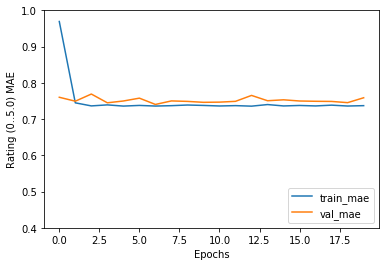

In [29]:
layer1 = 10
layer2 = 100
batch_size = 10
model = models.Sequential()
model.add(layers.Dense(layer1, input_dim=nmovies+nusers, activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.00001))) # input_shape=(n,nmovies)

model.add(layers.Dense(layer2, activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.00001)))
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(1))

opt = optimizers.RMSprop()

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mae'])
#model.summary()

history = model.fit(X, y,
                    shuffle=True,
                    epochs=20,
                    validation_split=0.15,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

plt.ylabel("Rating (0..5.0) MAE")
plt.xlabel("Epochs")
accur = history.history['mae']
plt.plot(accur, label='train_mae')
val_accur = history.history['val_mae']
plt.plot(val_accur, label='val_mae')
# plt.xlim(0, 200)
plt.ylim(0.4, 1.00)
plt.legend(loc='lower right')
plt.show()